In [1]:
import numpy as np
import theano.tensor as T
from lasagne.layers import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.updates import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from visualize import draw_to_file
from IPython.display import Image

In [3]:
import load_mnist

In [4]:
X_train, y_train, _, _, _, _ = load_mnist.load_dataset()

--------

In [375]:
def get_net():
    l_in = InputLayer((None, 1, 28, 28))
    conv = l_in
    conv = Conv2DLayer(conv, num_filters=32, filter_size=3, stride=2)
    conv = Conv2DLayer(conv, num_filters=48, filter_size=3, stride=2)
    conv = Conv2DLayer(conv, num_filters=64, filter_size=3, stride=2)
    mean = DenseLayer(conv, num_units=64, nonlinearity=linear)
    var = DenseLayer(conv, num_units=64, nonlinearity=linear)
    l_eps = InputLayer(var.output_shape)
    l_eps = ExpressionLayer(l_eps, lambda elem: T.exp(l_eps / 2.))
    eps_x_var = ElemwiseMergeLayer([l_eps, var], merge_function=T.mul)
    plus_mean = ElemwiseSumLayer([eps_x_var,mean])
    # decoding
    dconv = DenseLayer(plus_mean, num_units=np.prod(conv.output_shape[1::]))
    cos = conv.output_shape
    dconv = ReshapeLayer(dconv, (-1, cos[1], cos[2], cos[3]))
    dconv = Deconv2DLayer(dconv, num_filters=48, filter_size=4, stride=2)
    dconv = Deconv2DLayer(dconv, num_filters=32, filter_size=4, stride=2, crop=0)
    dconv = Deconv2DLayer(dconv, num_filters=1, filter_size=4, stride=2, crop=1, nonlinearity=sigmoid)
    ########
    out = dconv
    code = plus_mean
    return l_in, out, mean, var, code, l_eps
    
    #return {'in':l_in, 'out':out, 'code':code, 'eps':l_eps}

In [59]:
def get_net_mlp(latent_dim=32):
    l_in = InputLayer((None, 1, 28, 28))
    conv = FlattenLayer(l_in)
    conv = DenseLayer(conv, num_units=256)
    mean = DenseLayer(conv, num_units=latent_dim, nonlinearity=linear)
    var = DenseLayer(conv, num_units=latent_dim, nonlinearity=linear)
    l_eps = InputLayer(var.output_shape)
    l_eps = ExpressionLayer(l_eps, lambda elem: T.exp(l_eps / 2.))
    eps_x_var = ElemwiseMergeLayer([l_eps, var], merge_function=T.mul)
    plus_mean = ElemwiseSumLayer([eps_x_var,mean])
    # decoding
    dconv = DenseLayer(plus_mean, num_units=256)
    dconv = DenseLayer(dconv, num_units=784, nonlinearity=sigmoid)
    dconv = ReshapeLayer(dconv, (-1, 1, 28, 28))
    ########
    out = dconv
    code = plus_mean
    return l_in, out, mean, var, code, l_eps
    
    #return {'in':l_in, 'out':out, 'code':code, 'eps':l_eps}

In [120]:
l_in, l_out, l_mean, l_var, l_code, l_eps = get_net_mlp(2)

In [62]:
count_params(l_out)

404244

In [63]:
draw_to_file(get_all_layers(l_out), "graph.png", verbose=True)

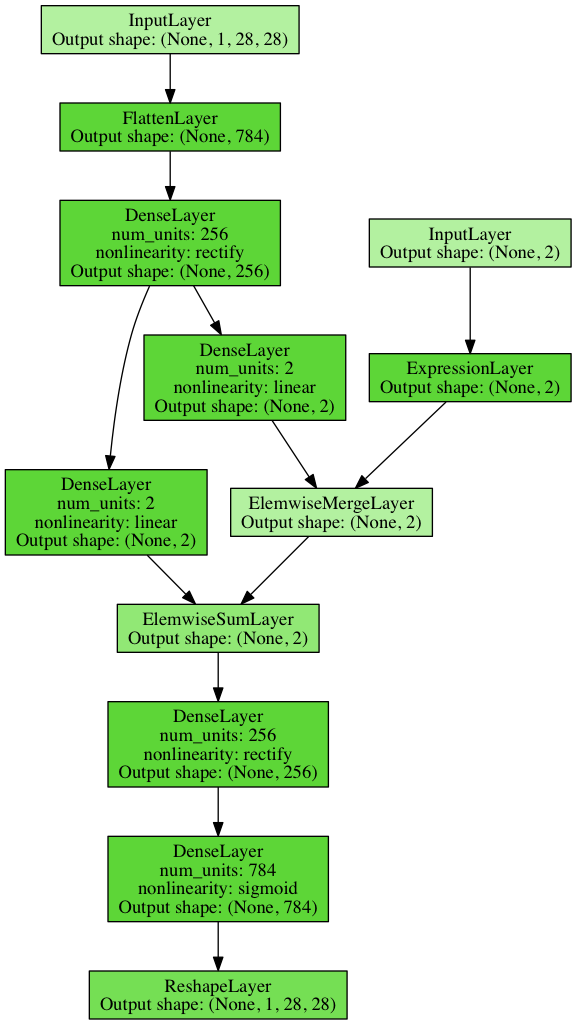

In [64]:
Image("graph.png")

In [65]:
count_params(l_out)

404244

In [66]:
sampler = lambda bs: np.random.normal(0,1,size=(bs, l_code.output_shape[-1])).astype("float32")

In [67]:
print "in ->", l_in.output_shape
print "out ->", l_out.output_shape
print "code ->", l_code.output_shape
print "mean ->", l_mean.output_shape
print "var ->", l_var.output_shape
print "eps ->", l_eps.output_shape

in -> (None, 1, 28, 28)
out -> (None, 1, 28, 28)
code -> (None, 2)
mean -> (None, 2)
var -> (None, 2)
eps -> (None, 2)


In [121]:
x = T.tensor4('x')
z = T.fmatrix('z')

In [122]:
net_out, mean_out, var_out = get_output([l_out, l_mean, l_var], {l_in:x, l_eps:z})

In [712]:
#recon_loss = squared_error(x, net_out).mean()
#recon_loss = binary_crossentropy(net_out, x).mean()

In [713]:
#kl_loss = -0.5 * T.sum(1 + var_out - T.square(mean_out) - T.exp(var_out), axis=-1)

In [714]:
#tot_loss = recon_loss + 0.001*kl_loss.mean()

In [123]:
#recon_loss = 784 * binary_crossentropy(net_out, x)
#kl_loss = - 0.5 * T.sum(1 + var_out - T.square(mean_out) - T.exp(var_out), axis=-1)
#tot_loss = recon_loss.mean() + kl_loss.mean()
recon_loss = binary_crossentropy(net_out, x)
kl_loss = - 0.5 * T.sum(1 + var_out - T.square(mean_out) - T.exp(var_out), axis=-1)
tot_loss = recon_loss.mean() + (1./784.)*kl_loss.mean()

In [124]:
loss_fn = theano.function([x,z], [tot_loss, recon_loss, kl_loss])

--------

In [125]:
out_fn = theano.function([x,z], net_out)

In [126]:
net_out_z_only = get_output(l_out, {l_code:z})

In [127]:
out_fn_z_only = theano.function([z], net_out_z_only)

In [128]:
def iterator(xx, bs):
    idxs = np.arange(0, xx.shape[0])
    np.random.shuffle(idxs)
    for b in range(xx.shape[0] // bs):
        yield xx[b*bs:(b+1)*bs], sampler(bs)

In [129]:
params = get_all_params(l_out, trainable=True)
params

[W, b, W, b, W, b, W, b, W, b]

In [130]:
updates = adam(tot_loss, params, learning_rate=1e-3)

In [131]:
train_fn = theano.function([x,z], [tot_loss, recon_loss, kl_loss], updates=updates)

In [134]:
for epoch in range(0,100):
    tot_a,tot_b,tot_c = [], [], []
    for x_batch, z_batch in iterator(X_train, 32):
        aa,bb,cc = train_fn(x_batch, z_batch)
        tot_a.append(aa)
        tot_b.append(bb)
        tot_c.append(cc)
    print epoch+1, np.mean(tot_a), np.mean(tot_b), np.mean(tot_c)

1 0.192784111729 0.191886873491 0.703434778629
2 0.192201609205 0.191305220011 0.702769128159
3 0.191702556979 0.190808660289 0.700815004969
4 0.191207988077 0.190318911241 0.69703623964
5 0.190756341422 0.18987046827 0.694524551431
6 0.190316916532 0.189434861265 0.691531328725
7 0.189930151378 0.189050345595 0.689767734076
8 0.189583138279 0.188709463428 0.68496108303
9 0.189240741838 0.188370348709 0.682388213
10 0.188926309307 0.188059344491 0.679700416215
11 0.188626095059 0.187758378142 0.680290062581


KeyboardInterrupt: 

In [47]:
from scipy.stats import norm

In [152]:
def output_grid():
    # display a 2D manifold of the digits
    n = 15  # figure with 15x15 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
    # to produce values of the latent variables z, since the prior of the latent space is Gaussian
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]]).astype("float32")
            x_decoded = out_fn_z_only(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    return figure

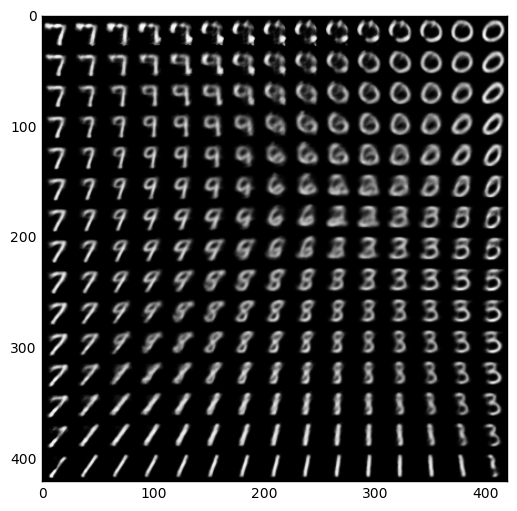

In [153]:
plt.figure(figsize=(6,6))

plt.imshow(output_grid(),cmap="gray")

In [154]:
fn_mean_var = theano.function([x], [mean_out, var_out])

In [155]:
#this_mean, this_var = fn_mean_var(X_train[0:100])
this_mean, this_var = fn_mean_var(X_train[0:100])

(array([  5.,  12.,  28.,  39.,  43.,  33.,  16.,  12.,   6.,   6.]),
 array([-1.88127594, -1.44515459, -1.00903323, -0.57291188, -0.13679052,
         0.29933083,  0.73545218,  1.17157354,  1.60769489,  2.04381625,
         2.4799376 ]),
 <a list of 10 Patch objects>)

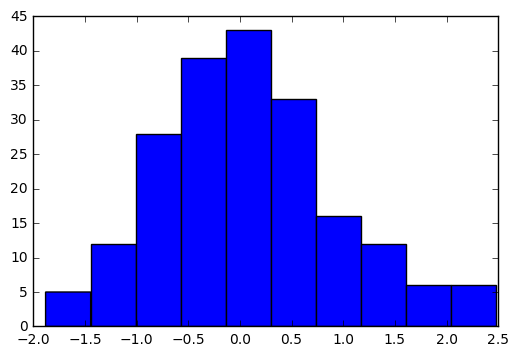

In [156]:
plt.hist(this_mean.flatten())

(array([  2.,   1.,   4.,  21.,  52.,  79.,  23.,   7.,   9.,   2.]),
 array([ 0.91695079,  0.93217338,  0.94739598,  0.96261857,  0.97784116,
         0.99306376,  1.00828635,  1.02350895,  1.03873154,  1.05395413,
         1.06917673]),
 <a list of 10 Patch objects>)

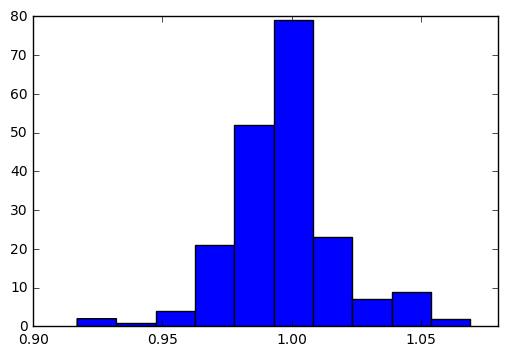

In [157]:
plt.hist(np.exp(this_var).flatten())

In [165]:
def random_interp():
    z1 = sampler(1)
    z2 = sampler(1)
    c = 0
    row = np.zeros((28, 28*10))
    for j in [0.,.1,.2,.3,.4,.5,.6,.7,.8,.9]:
        out = out_fn_z_only(j*z1 + (1-j)*z2)[0][0]
        row[:,c*28:(c+1)*28] = out
        c += 1
    return row

(-0.5, 279.5, 27.5, -0.5)

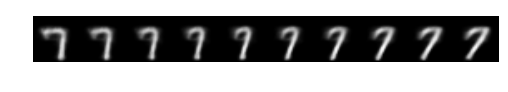

In [178]:
plt.imshow(random_interp(),cmap="gray")
plt.axis('off')